In [1]:
import pandas as pd
from pathlib import Path

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os


In [3]:
train = pd.read_csv("../input/plant-pathology-2020-fgvc7/train.csv")
test = pd.read_csv("../input/plant-pathology-2020-fgvc7/test.csv")


In [4]:
train


,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,1,0
1,Train_1,1,0,0,0
2,Train_2,0,0,1,0
3,Train_3,1,0,0,0
4,Train_4,0,0,1,0
...,...,...,...,...,...
1633,Train_1633,1,0,0,0
1634,Train_1634,0,1,0,0
1635,Train_1635,1,0,0,0
1636,Train_1636,0,0,0,1


In [5]:
test


,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4
...,...
178,Test_178
179,Test_179
180,Test_180
181,Test_181


In [6]:
import cv2
import matplotlib.pyplot as plt


In [7]:
base_path = "../input/plant-pathology-2020-fgvc7/images/"
def read_img(img_path):
    img = cv2.imread(base_path + img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


In [8]:
import tqdm
# height = []
# width = []
# channels = []
# for file in tqdm.tqdm(train["image_id"]):
#     img = read_img(file + ".jpg")
#     height.append(img.shape[0])
#     width.append(img.shape[1])
#     channels.append(img.shape[2])

# for file in train["image_id"]:
#     img = read_img(file + ".jpg")
#     height.append(img.shape[0])
#     width.append(img.shape[1])
#     channels.append(img.shape[2])


In [9]:
# train["height"] = height
# train["width"] = width
# train["channels"] = channels


In [10]:
# train["height"].hist()


In [11]:
# train["height"].value_counts()


In [12]:
# train["width"].hist()


In [13]:
# train["width"].value_counts()


In [14]:
# train["channels"].hist()


In [15]:
img_size = 256
def resize_to_square(im, img_size = img_size):
    old_size = im.shape[:2] # old_size is in (height, width) format
    ratio = float(img_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    # new_size should be in (width, height) format
    im = cv2.resize(im, (new_size[1], new_size[0]), cv2.INTER_NEAREST)
    delta_w = img_size - new_size[1]
    delta_h = img_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    return new_im


In [16]:
# del test_imgs
train_imgs = np.zeros([train.shape[0], 256, 256, 3])
for i, file in enumerate(tqdm.tqdm(train["image_id"])):
    img = read_img(file + ".jpg")
    img = resize_to_square(img)
    train_imgs[i] = img


100%|██████████| 1638/1638 [00:21<00:00, 75.81it/s]


In [17]:
from tensorflow import keras


2025-08-17 05:27:10.690394: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755408430.703622       8 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755408430.707594       8 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-17 05:27:10.723027: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
img_input = keras.layers.Input(shape=(256,256,3))
hidden1 = keras.layers.Conv2D(8, kernel_size = (3,3), activation="relu")(img_input)
hidden1 = keras.layers.MaxPool2D()(hidden1)
hidden1 = keras.layers.Conv2D(16, kernel_size = (3,3), activation="relu")(hidden1)
hidden1 = keras.layers.MaxPool2D()(hidden1)
hidden1 = keras.layers.Conv2D(32, kernel_size = (3,3), activation="relu")(hidden1)
hidden1 = keras.layers.MaxPool2D()(hidden1)
hidden1 = keras.layers.Conv2D(64, kernel_size = (3,3), activation="relu")(hidden1)
hidden1 = keras.layers.MaxPool2D()(hidden1)
hidden1 = keras.layers.Conv2D(128, kernel_size = (3,3), activation="relu")(hidden1)
hidden1 = keras.layers.MaxPool2D()(hidden1)
hidden1 = keras.layers.Conv2D(256, kernel_size = (3,3), activation="relu")(hidden1)
hidden1 = keras.layers.GlobalMaxPooling2D()(hidden1)
hidden1 = keras.layers.Dense(64)(hidden1)
hidden1 = keras.layers.Dense(32)(hidden1)
hidden1 = keras.layers.Dropout(.2)(hidden1)
output = keras.layers.Dense(4, activation = "softmax")(hidden1)
model = keras.models.Model(inputs=[img_input], outputs=[output])


2025-08-17 05:27:16.148326: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [19]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 412,212 (1.57 MB)

 Trainable params: 412,212 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
target_cols = ["healthy", "multiple_diseases","rust", "scab"]


In [21]:
y_train = train[target_cols].values


In [22]:
train_imgs.shape


(1638, 256, 256, 3)

In [23]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=.001), metrics = ["accuracy"])
history = model.fit(train_imgs, y_train, epochs=20, batch_size = 128)


ValueError: Argument(s) not recognized: {'lr': 0.001}

In [24]:
del train_imgs
test_imgs = np.zeros([test.shape[0], 256, 256, 3])  
for i, file in enumerate(tqdm.tqdm(test["image_id"])):
    img = read_img(file + ".jpg")
    img = resize_to_square(img)
    test_imgs[i] = img


100%|██████████| 183/183 [00:02<00:00, 77.72it/s]


In [25]:
test_preds = model.predict(test_imgs, batch_size = 128, verbose = True)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(128, 256, 256, 3))
  warnings.warn(msg)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step


In [26]:
test_preds.shape


(183, 4)

In [27]:
test[target_cols] = pd.DataFrame(test_preds, columns = target_cols)


In [28]:
test.to_csv("submission.csv", index = False)


In [29]:
test


,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.999992,1.700425e-10,1.689690e-20,7.692463e-06
1,Test_1,1.000000,4.707198e-12,4.779921e-27,3.466742e-08
2,Test_2,0.999998,4.084764e-12,5.745276e-27,2.284470e-06
3,Test_3,0.999999,2.769872e-13,3.382758e-24,4.206063e-07
4,Test_4,1.000000,1.332427e-16,1.162735e-31,7.686730e-11
...,...,...,...,...,...
178,Test_178,0.999995,8.561618e-13,3.293588e-22,5.012803e-06
179,Test_179,0.999974,1.556862e-10,8.890627e-24,2.582642e-05
180,Test_180,1.000000,4.797741e-16,5.088641e-29,1.086910e-10
181,Test_181,1.000000,6.792284e-13,1.100878e-21,4.841490e-07


In [30]:
sample_sub = pd.read_csv("../input/plant-pathology-2020-fgvc7/sample_submission.csv")


In [31]:
sample_sub


,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.25,0.25,0.25,0.25
1,Test_1,0.25,0.25,0.25,0.25
2,Test_2,0.25,0.25,0.25,0.25
3,Test_3,0.25,0.25,0.25,0.25
4,Test_4,0.25,0.25,0.25,0.25
...,...,...,...,...,...
178,Test_178,0.25,0.25,0.25,0.25
179,Test_179,0.25,0.25,0.25,0.25
180,Test_180,0.25,0.25,0.25,0.25
181,Test_181,0.25,0.25,0.25,0.25


healthy


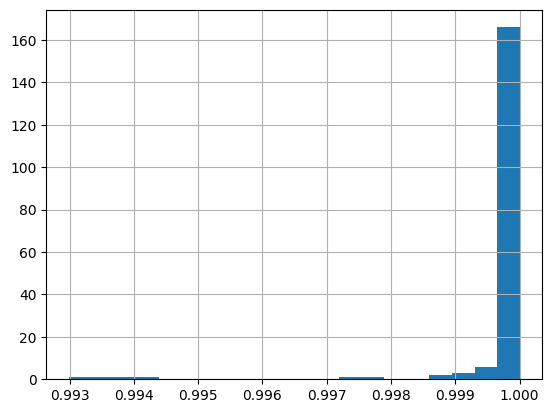

multiple_diseases


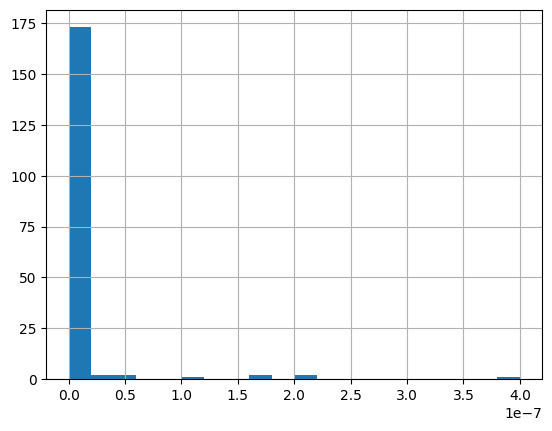

rust


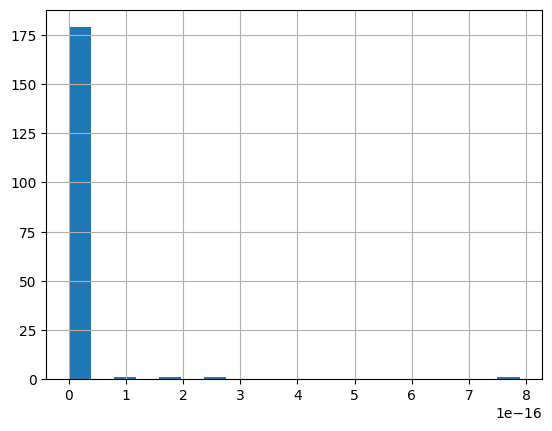

scab


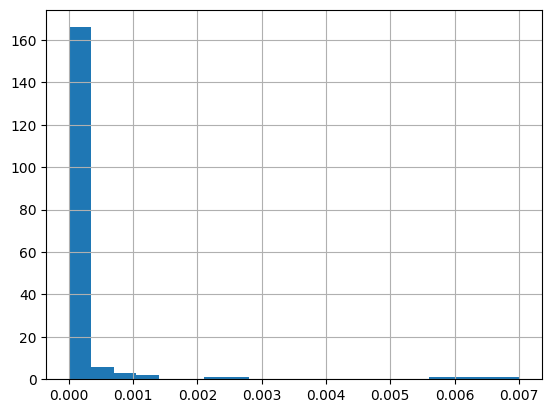

In [32]:
for col in target_cols:
    print(col)
    test[col].hist(bins = 20)
    plt.show()
